## Import Libraries

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import re
import datetime
import seaborn as sns

from pyspark.sql import SQLContext, SparkSession
import  pyspark.sql.functions as F
import findspark
findspark.init()
import pyspark
from pyspark.ml.feature import Tokenizer, StopWordsRemover, RegexTokenizer
from pyspark.sql.types import ArrayType, StringType

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer as keras_tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense, \
       Bidirectional, SpatialDropout1D, GlobalMaxPool1D, Dropout # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

In [2]:
#Starting Spark Session
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .config("spark.driver.memory","16G")\
    .config('spark.executor.memory', '8G') \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.3.0") \
    .getOrCreate()
spark

### Import Restaurant Attributes

In [3]:
rest_attrs_file = '../data/input/rest_attributes/rest_attrs_compiled.json'
df_rest_attrs =  spark.read.option("multiLine", "true").option("mode", "PERMISSIVE").json(rest_attrs_file)
df_rest_attrs = df_rest_attrs.withColumn('rest_type', F.regexp_replace(F.lower(F.col('rest_type')), ' restaurant', ''))
df_rest_attrs = df_rest_attrs.withColumn('rest_type', F.regexp_replace(F.lower(F.col('rest_type')), ' shop', ''))

print('Total Number of Restaurants',df_rest_attrs.count())
raw_rest_types = df_rest_attrs.select('rest_type').distinct().count()
print('Total unique/distinct restaurant types = ', raw_rest_types)

Total Number of Restaurants 73507
Total unique/distinct restaurant types =  741


In [4]:
tot = df_rest_attrs.count()
df_rest_attrs.groupBy("rest_type") \
  .count() \
  .withColumnRenamed('count', 'cnt_per_group') \
  .withColumn('perc_of_count_total', (F.col('cnt_per_group') / tot) * 100 ) \
  .sort(F.col('perc_of_count_total').desc()) \
  .show(n=20 ,truncate=False)

+-----------+-------------+-------------------+
|rest_type  |cnt_per_group|perc_of_count_total|
+-----------+-------------+-------------------+
|restaurant |12174        |16.561688002503164 |
|mexican    |4879         |6.6374630987525    |
|pizza      |3526         |4.796822071367353  |
|null       |2949         |4.011862815786252  |
|chinese    |2830         |3.849973471914239  |
|fast food  |2759         |3.7533840314527867 |
|sandwich   |2667         |3.6282258832492142 |
|american   |2382         |3.240507706749017  |
|italian    |2063         |2.8065354319996736 |
|coffee     |2046         |2.7834083828751006 |
|seafood    |1208         |1.6433809024990815 |
|japanese   |1195         |1.6256955119920553 |
|bar & grill|1162         |1.5808018283972955 |
|thai       |1119         |1.5223039982586692 |
|sushi      |1085         |1.4760499000095229 |
|hamburger  |1028         |1.3985062647094835 |
|chicken    |1010         |1.3740188009305236 |
|cafe       |909          |1.23661692083

###  FIltering and Categorizing Restaurant Types

In [5]:
def rem_non_rest_type(df_rest_attributes):
    df_clean_rest_attr = df_rest_attributes.filter(~(F.lower(F.col('rest_type')).rlike('stand|venue|club|mall|alley|market|store|association|\
                                                      |station|juice|ice cream|center|theater|cater|court|fuel|\
                                                      |tobacco|arcade|producer|winery|yogurt|hall|school|grovery|service|\
                                                      |apartment|agency|organization|atm|estate|office|casino|\
                                                      |company|consultant|gift|deli')))
    return df_clean_rest_attr

In [6]:
df_clean_rest_attr  = rem_non_rest_type(df_rest_attrs)
df_clean_rest_attr.show(n=3)

+-----+-----+----+----+----+----+----+----+-----------+-------------+--------------------+-------------+--------------------+--------------------+------------+
|12 AM|12 PM|3 AM|3 PM|6 AM|6 PM|9 AM|9 PM|        cbg|no_of_reviews|            place_id|price_range_$|         rest_labels|        rest_summary|   rest_type|
+-----+-----+----+----+----+----+----+----+-----------+-------------+--------------------+-------------+--------------------+--------------------+------------+
| null| 67.0|null|20.0| 0.0| 0.0| 0.0| 0.0|60710011041|        911.0|ChIJ1YUZhN8zw4AR9...|          2.0|[Dine-in, Takeout...|Relaxed restauran...|   soul food|
| null| 51.0| 0.0|53.0|52.0|44.0|89.0|20.0|60710011041|       1038.0|ChIJldVMgt8zw4ARb...|          2.0|[Dine-in, Takeout...|Seattle-based cof...|      coffee|
| null| 62.0|null|37.0| 0.0|79.0| 0.0| 0.0|60710011041|        155.0|ChIJLW9did4zw4ARg...|          1.0|[Takeout, No-cont...|Teriyaki bowls wi...|asian fusion|
+-----+-----+----+----+----+----+----+--

In [7]:
df_rest_type_merged = df_clean_rest_attr.withColumn('rest_type', 
             F.when(F.lower(F.col('rest_type')).rlike('taco|mexican|burrito|mex'), F.lit('mexican'))\
              .when(F.lower(F.col('rest_type')).rlike('bar|pub|brewery|beer|gastropub|brasserie|bistro'), F.lit('bar'))\
              .when(F.lower(F.col('rest_type')).rlike('pizza'), F.lit('pizza'))\
              .when(F.lower(F.col('rest_type')).rlike('irish|fish & chips|fish and chips'), F.lit('irish'))\
              .when(F.lower(F.col('rest_type')).rlike('indian|pakistan|nepalese'), F.lit('indian'))\
              .when(F.lower(F.col('rest_type')).rlike('chinese|dim|sichuan|noodle|mandarin|shang|hong|\
                                                      |hot pot|餐馆|cantonese|dumpling'), F.lit('chinese'))\
              .when(F.lower(F.col('rest_type')).rlike('american|us|hot dog|diner|southern|cajun'), F.lit('american'))\
              .when(F.lower(F.col('rest_type')).rlike('ramen|japanese|izakaya'), F.lit('japanese'))\
              .when(F.lower(F.col('rest_type')).rlike('sushi'), F.lit('sushi'))\
              .when(F.lower(F.col('rest_type')).rlike('steak'), F.lit('steak'))\
              .when(F.lower(F.col('rest_type')).rlike('thai|cambodia'), F.lit('thai'))\
              .when(F.lower(F.col('rest_type')).rlike('chicken'), F.lit('fast food'))\
              .when(F.lower(F.col('rest_type')).rlike('vietnamese|pho'), F.lit('vietnamese'))\
              .when(F.lower(F.col('rest_type')).rlike('italian|pasta'), F.lit('italian'))\
                                          .when(F.lower(F.col('rest_type')).rlike('portuguese|salvadoran|peru|\
                                                    |cuban|brazilian|honduran|latin|guatemalan|ecuadorian|\
                                                      |argentinian|venezuelan|colombian|dominican|nicaraguan')\
                    , F.lit('latin american'))\
                                     
              
              .when(F.lower(F.col('rest_type')).rlike('greek|gyro|falafel|middle eastern|afghani|persian|\
                                                  |halal|kebab|mediterranean|middle eastern|lebanese'), F.lit('mediterranean'))\
              .when(F.lower(F.col('rest_type')).rlike('korean|한식당|음식점'), F.lit('korean'))\
              .when(F.lower(F.col('rest_type')).rlike('french|crêperie|crepe'), F.lit('french'))\
              .when(F.lower(F.col('rest_type')).rlike('lounge|bistro'), F.lit('bistro'))\
              .when(F.lower(F.col('rest_type')).rlike('burger|sandwich'), F.lit('burger'))\
              .when(F.lower(F.col('rest_type')).rlike('brunch|breakfast|pancake'), F.lit('brunch'))\
              .when(F.lower(F.col('rest_type')).rlike('coffee|cafe|bake|bakery|donut|bagel'), F.lit('cafe&bakery'))\
              .when(F.lower(F.col('rest_type')).rlike('southern|soul food'), F.lit('southern'))\
              .when(F.lower(F.col('rest_type')).rlike('spanish|tapas'), F.lit('spanish'))\
              .when(F.lower(F.col('rest_type')).rlike('asian'), F.lit('asian'))\
              .when(F.lower(F.col('rest_type')).rlike('european|german|polish|belgian|british|swedish|irish'), F.lit('european'))\
              .when(F.lower(F.col('rest_type')).rlike('african'), F.lit('african'))\
              .when(F.lower(F.col('rest_type')).rlike('vegan|vegetarian'), F.lit('vegetarian'))\
              .otherwise(F.lit(F.col('rest_type')))              
                         )
df_rest_type_merged = df_rest_type_merged.where('rest_type != "remove"')
rest_types = df_rest_type_merged.select('rest_type').distinct().count()
print('Total unique/distinct restaurant types after cleaning = ', rest_types)

Total unique/distinct restaurant types after cleaning =  342


### Top 50 Restaurant Types by Percentage of Total

In [8]:
tot = df_rest_type_merged.count()
df_rest_type_merged.groupBy("rest_type") \
  .count() \
  .withColumnRenamed('count', 'cnt_per_group') \
  .withColumn('perc_of_count_total', (F.col('cnt_per_group') / tot) * 100 ) \
  .sort(F.col('perc_of_count_total').desc()) \
  .show(n=50 ,truncate=False)

+--------------+-------------+-------------------+
|rest_type     |cnt_per_group|perc_of_count_total|
+--------------+-------------+-------------------+
|restaurant    |12174        |18.219641413990242 |
|american      |6231         |9.325331497500674  |
|mexican       |5615         |8.403424227004699  |
|bar           |4545         |6.802059325331497  |
|fast food     |4374         |6.546140261606154  |
|burger        |3695         |5.529947020264     |
|pizza         |3667         |5.488042144332366  |
|cafe&bakery   |3604         |5.393756173486186  |
|chinese       |3520         |5.268041545691281  |
|italian       |2097         |3.1383758867371068 |
|latin american|1815         |2.716333921997067  |
|mediterranean |1672         |2.502319734203358  |
|japanese      |1635         |2.446945433865126  |
|seafood       |1208         |1.8078960759076896 |
|thai          |1144         |1.7121135023496663 |
|indian        |908          |1.3589152623544554 |
|brunch        |739          |1

## Top 15 Restaurant Categories

In [9]:
rest_types_unknown_categories = ['restaurant', 'takeout', 'fine dining','grill','organic', 'vegetarian', 'brunch',
                              'lunch', 'health food','asian','family', 'delivery']

df_rest_type_merged = df_rest_type_merged.filter(~df_rest_type_merged.rest_type.isin(rest_types_unknown_categories))

tot = df_rest_type_merged.count()

top_rest_categories = df_rest_type_merged.groupBy("rest_type") \
  .count() \
  .withColumnRenamed('count', 'cnt_per_group') \
  .withColumn('perc_of_count_total', (F.col('cnt_per_group') / tot) * 100 ) \
  .sort(F.col('perc_of_count_total').desc()).limit(15).select('rest_type').collect()
top_15_rest_categories = [row.rest_type for row in top_rest_categories]
df_attrs_top = df_rest_type_merged.filter(df_rest_type_merged.rest_type.isin(top_15_rest_categories))
tot = df_attrs_top.count()
df_attrs_top.groupBy("rest_type") \
  .count() \
  .withColumnRenamed('count', 'cnt_per_group') \
  .withColumn('perc_of_count_total', (F.col('cnt_per_group') / tot) * 100 ) \
  .sort(F.col('perc_of_count_total').desc()) \
  .show()

+--------------+-------------+-------------------+
|     rest_type|cnt_per_group|perc_of_count_total|
+--------------+-------------+-------------------+
|      american|         6231| 13.625628690137765|
|       mexican|         5615| 12.278591734091405|
|           bar|         4545|  9.938771047452438|
|     fast food|         4374|  9.564837087251258|
|        burger|         3695|  8.080034987972883|
|         pizza|         3667|  8.018806035425323|
|   cafe&bakery|         3604|  7.881040892193308|
|       chinese|         3520|  7.697354034550623|
|       italian|         2097|  4.585611196151323|
|latin american|         1815|  3.968948174065165|
| mediterranean|         1672| 3.6562431664115462|
|      japanese|         1635|  3.575333479116553|
|       seafood|         1208| 2.6415919527662366|
|          thai|         1144| 2.5016400612289527|
|        indian|          908| 1.9855674611852177|
+--------------+-------------+-------------------+



### Import Review Files

In [10]:
op_path = '../data/input/review_files/'
op_files = [op_path + f for f in os.listdir(op_path) ]
df_reviews = spark.read.parquet(*op_files)
print('Total Number of Raw Reviews = ',df_reviews.count())

Total Number of Raw Reviews =  19567851


In [11]:
def clean_reviews(df_rest_attributes, df_rest_reviews):
    df_rem_dup = df_rest_reviews.drop_duplicates(subset = ['place_id', 'review_id'])

    df_filter_rev = df_rem_dup.withColumn('Review_Length', F.length('review')).filter(F.col('Review_Length') >30)

    df_rev_list = df_filter_rev.groupby('place_id').agg(F.collect_list('review').alias("reviews"))
    df_combine_revs = df_rev_list.withColumn("reviews", F.concat_ws(". ", "reviews"))

    df_merge_rest_type_revs = df_rest_attributes.select('place_id', 'rest_type','rest_summary')\
                    .join(df_combine_revs.select('place_id', 'reviews'), 'place_id', 'inner')
    
    return df_merge_rest_type_revs
    

## Cleaning and Tokenization of Reviews

In [13]:
def tokenize(df_rest_reviews):
    from pyspark.ml.feature import Tokenizer, StopWordsRemover, RegexTokenizer
    stopwordList = ["good","food","yet", "place","translated", "google", 'great', 'delicious', 'like' ] 
    stopwordList.extend(StopWordsRemover().getStopWords())
    df_rest_reviews_lower = df_rest_reviews.withColumn('reviews', F.lower(F.col('reviews')))
    df_reviews_rem_html = df_rest_reviews_lower.select('place_id','rest_type', \
                                  (F.lower(F.regexp_replace('reviews', "<.*?>", " ")).alias('reviews')))
    df_reviews_rem_symbols = df_reviews_rem_html.select('place_id','rest_type', \
                               (F.lower(F.regexp_replace('reviews', "[^a-zA-Z\\s]", " ")).alias('reviews')))

    def filter_empty(l):
        return filter(lambda x: x is not None and len(x) > 0, l)
    

    tokenizer = Tokenizer(inputCol="reviews", outputCol="review_tokens")
    df_reviews_tokens = tokenizer.transform(df_reviews_rem_symbols).select('place_id','rest_type','review_tokens')
    remover = StopWordsRemover(inputCol='review_tokens', outputCol='words_clean',stopWords=stopwordList)
    df_reviews_clean = remover.transform(df_reviews_tokens).select('place_id','rest_type', 'words_clean')

    df_clean_reviews = df_reviews_clean.withColumn("words_clean", F.expr("filter(words_clean, elem -> elem != '')"))
    
    return df_clean_reviews

In [14]:
def spark_prep(df_rest_attributes, df_rest_reviews):
    df_combined = clean_reviews(df_rest_attributes, df_rest_reviews)
    df_clean_reviews = tokenize(df_combined)
    return df_clean_reviews

In [15]:
df_clean_reviews = spark_prep(df_attrs_top, df_reviews)
df_clean_reviews.show(10)

+--------------------+-------------+--------------------+
|            place_id|    rest_type|         words_clean|
+--------------------+-------------+--------------------+
|ChIJ-0J6oCi32YgRh...|     american|[discovered, amaz...|
|ChIJ-1UjJEBgwokR6...|      chinese|[coming, years, p...|
|ChIJ-1ZeYqWbTYcRh...|mediterranean|[showed, one, eve...|
|ChIJ-TAC4DV544kRi...|        pizza|[used, love, orde...|
|ChIJ-TsHx4H0wokRY...|  cafe&bakery|[favorite, go, fo...|
|ChIJ-xHjVLe2xokR2...|        pizza|[best, classic, p...|
|ChIJ0Sh6bsjNjIgRk...|     american|[excellent, servi...|
|ChIJ0aM0QOBbwokRa...|  cafe&bakery|[quick, service, ...|
|ChIJ0x8Q6b5ZwokRM...|     american|[worried, bad, ne...|
|ChIJ1-wy9VSVwoARs...|    fast food|[delivered, via, ...|
+--------------------+-------------+--------------------+
only showing top 10 rows



## Distribution of Restaurant Types after Cleaning Reviews

In [16]:
tot = df_clean_reviews.count()
df_clean_reviews.groupBy("rest_type") \
  .count() \
  .withColumnRenamed('count', 'cnt_per_group') \
  .withColumn('perc_of_count_total', (F.col('cnt_per_group') / tot) * 100 ) \
  .sort(F.col('perc_of_count_total').desc()) \
  .show()
df_clean_reviews.persist()


+--------------+-------------+-------------------+
|     rest_type|cnt_per_group|perc_of_count_total|
+--------------+-------------+-------------------+
|      american|         5885| 13.552725514128458|
|       mexican|         5232| 12.048914169909954|
|           bar|         4303|  9.909494968104461|
|     fast food|         3995|    9.2001934458697|
|        burger|         3545|  8.163876286760473|
|   cafe&bakery|         3542|  8.156967505699745|
|         pizza|         3504|   8.06945627893052|
|       chinese|         3346|   7.70559380973217|
|       italian|         2035|  4.686456486193952|
|latin american|         1765|  4.064666190728416|
| mediterranean|         1606|  3.698500794509822|
|      japanese|         1553|  3.576445662436958|
|       seafood|         1131| 2.6046104598945257|
|          thai|         1116|  2.570066554590885|
|        indian|          865| 1.9920318725099602|
+--------------+-------------+-------------------+



DataFrame[place_id: string, rest_type: string, words_clean: array<string>]

In [17]:
reviews = [row.words_clean for row in df_clean_reviews.select('words_clean').collect()]
rest_types = [row.rest_type for row in df_clean_reviews.select('rest_type').collect()]

## Prep Review Text

In [18]:
def load_dataset(x,y):
    
    x_data = pd.Series(x)       # Reviews/Input
    y_data_df = pd.Series(y)     # Sentiment/Output

    # Convert Rest Type Classes to Dummy Vectors
    y_data = pd.get_dummies(y_data_df)
    classes = y_data.columns.tolist()

    return x_data, y_data.values, classes

x_data, y_data,classes = load_dataset(reviews,rest_types)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1) 

Train Set
3571     [love, staff, amazing, sweet, kind, saw, us, l...
7244     [love, customer, service, drinks, awesome, hig...
4451     [extremely, slow, fast, experience, took, almo...
11574    [fried, rice, crispy, chicken, wings, really, ...
36381    [foot, vibes, atmosphere, nice, meal, ambiance...
dtype: object 

22023    [gave, star, required, rudest, establishment, ...
41230    [lula, logan, square, institution, consistentl...
9151     [service, prices, definitely, returning, overa...
28044    [actually, surprising, best, beef, udon, ve, e...
27199    [always, come, decent, service, decent, wait, ...
dtype: object 

Test Set
[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]] 

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]


## Tokens to Sequences

In [19]:
def get_max_length(x):
    review_length = []
    for review in x:
        review_length.append(len(review))
    return int(np.ceil(np.mean(review_length)))

In [20]:
def prep_data(x_list):
    token = keras_tokenizer(lower=False)
    token.fit_on_texts(x_list[0])
    tokenized_x = []
    for x in x_list:
        x_token = token.texts_to_sequences(x)
        tokenized_x.append(x_token)

    max_length = get_max_length(x_list[0])
    padded_x = []
    for x in tokenized_x:
        x_pad = pad_sequences(x, maxlen=max_length, padding='post', truncating='post')
        padded_x.append(x_pad)
    
    total_words = len(token.word_index) + 1
    return padded_x, total_words,max_length, token

In [25]:
[train,val,test] , total_words,max_len,token = prep_data([x_train,x_val,x_test])

In [26]:
word_counts = token.word_counts
{k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1], reverse=True)[:10]}

{'service': 1122751,
 'best': 479032,
 'staff': 451127,
 'time': 430035,
 'nice': 389269,
 'go': 384679,
 'friendly': 383860,
 'order': 370097,
 'one': 362725,
 'back': 362663}

In [22]:
def generate_model(total_words, max_len, EMBED_DIM = 512):
    model = Sequential()
    model.add(Embedding(input_dim=total_words, 
                               output_dim=EMBED_DIM, 
                               input_length=max_len))

    model.add(GlobalMaxPool1D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(15, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [23]:
def train_model(model,x,y, batch_size = 128, epochs = 5, val=None):
    if val:
        model.fit(x, y, validation_data= val,batch_size = batch_size, epochs = epochs)
    else:
        model.fit(x, y,batch_size = batch_size, epochs = epochs)
    return model

In [133]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [29]:
class_model  = generate_model(total_words, max_len)
print(class_model.summary())
train_model(class_model,train,y_train, val = (val,y_val))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2092, 512)         161033216 
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                9

KeyboardInterrupt: 

In [121]:
pred_df = pd.DataFrame(model.predict(test, batch_size=128), columns = classes)
preds = pred_df.idxmax(axis=1)
y_pred = preds.values

test_df = pd.DataFrame(y_test, columns = classes)
test = test_df.idxmax(axis=1)
y_tst = test.values

In [122]:
def plot_heatmap_mat(y_test,pred,classes,normalize=False ):
    sns.set_context("poster", rc={"font.size":18, 'figure.facecolor':'w'})
    sns.set({'figure.facecolor':'w'})
    conf_mx = confusion_matrix(y_test,pred)
    if normalize:
        row_sums = conf_mx.sum(axis=1, keepdims=True)
        norm_conf_mx = conf_mx / row_sums
        plot = sns.heatmap(norm_conf_mx, annot=True, square=True,
                    xticklabels=classes,yticklabels=classes, fmt='.2f',
                    linewidths=.2)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        return plot
    else:
        plot = sns.heatmap(conf_mx, annot=True, square=True,
                    xticklabels=classes,yticklabels=classes,fmt='d',
                    linewidths=.2)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        return plot

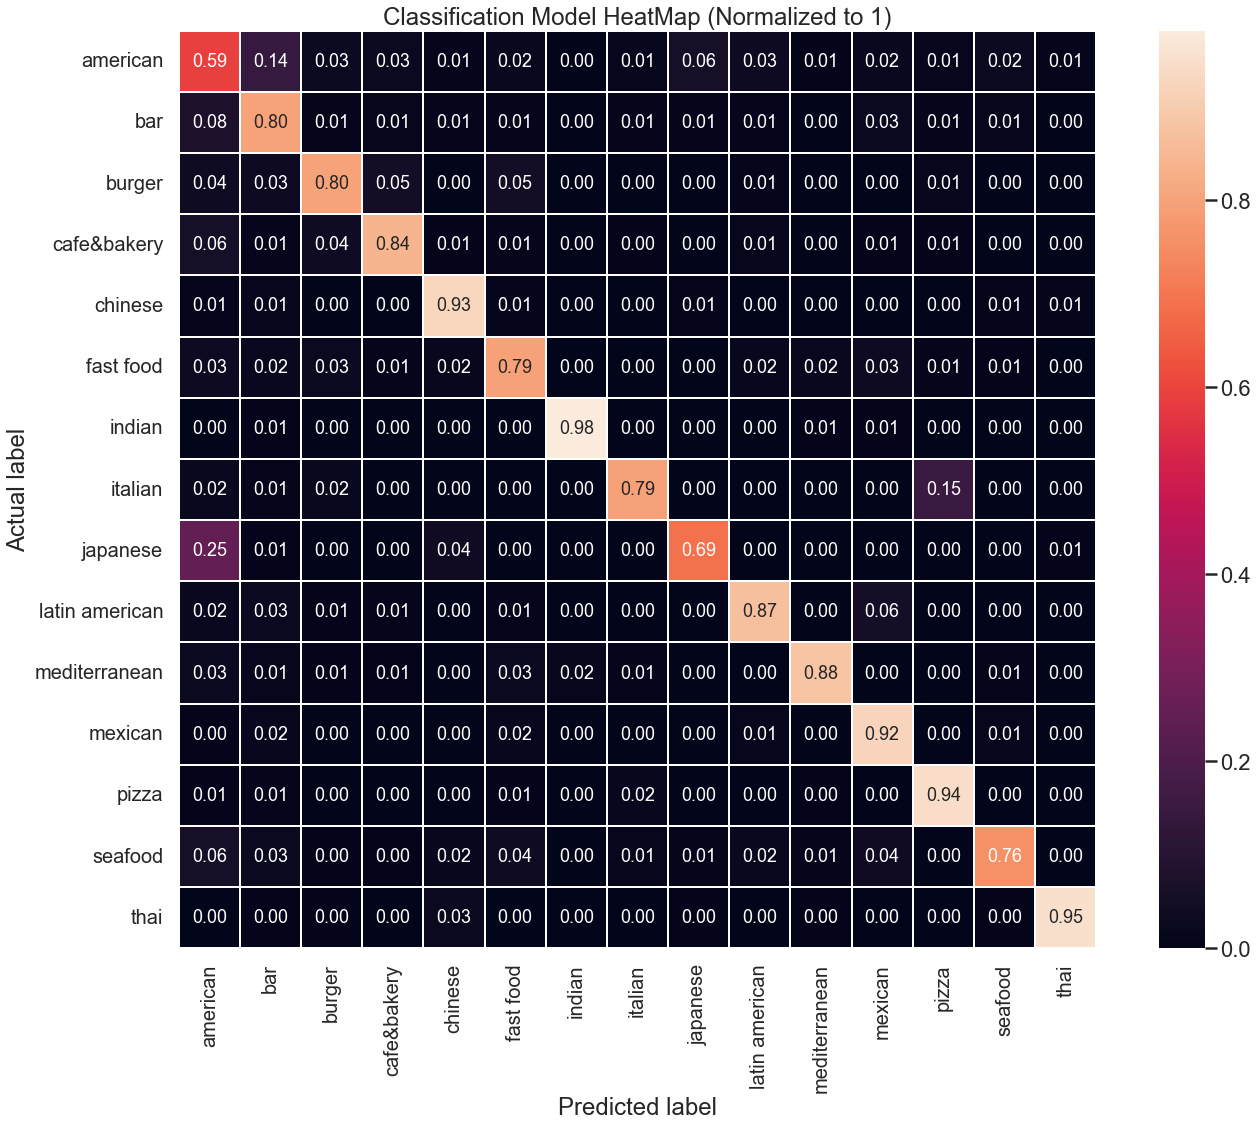

Accuracy: 81.85820727026417


In [124]:
fig = plt.figure(figsize=(20,16),facecolor='white')

ax1 =  plot_heatmap_mat(y_tst,y_pred,normalize=True,classes = classes)
ax1.title.set_text('Classification Model HeatMap (Normalized to 1)')

plt.tight_layout()
plt.savefig('../data/output/classification_heatmap_normalized.png',format = 'png')

plt.show()
print('Accuracy: {}'.format(accuracy_score(y_tst,y_pred)*100))

In [28]:
[train_x] , total_words,max_len,token = prep_data([x_data])
train_y = y_data
class_model  = generate_model(total_words, max_len)
print(class_model.summary())
model = train_model(class_model,train_x,train_y)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2094, 512)         195284992 
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 15)               

In [30]:
df_uncategorized_rest_types = df_clean_rest_attr.join(df_attrs_top, 'place_id', 'left_anti')
df_uncategorized_rest_types_combined = clean_reviews(df_uncategorized_rest_types, df_reviews)
df_uncategorized_rest_types_token = tokenize(df_uncategorized_rest_types_combined)
x = [row.words_clean for row in df_uncategorized_rest_types_token.select('words_clean').collect()]
x_token = token.texts_to_sequences(x)
x_unk = pad_sequences(x_token, maxlen=max_len, padding='post', truncating='post')


american          5763
bar               2178
fast food         1481
chinese           1448
mediterranean      995
mexican            972
cafe&bakery        878
burger             809
latin american     667
pizza              474
japanese           459
thai               379
seafood            335
italian            309
indian             145
dtype: int64


<AxesSubplot:>

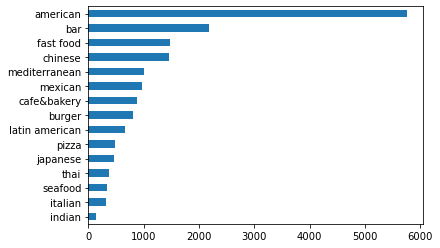

In [35]:
pred_df = pd.DataFrame(model.predict(x_unk, batch_size=128), columns = classes)
preds = pred_df.idxmax(axis=1)
print(preds.value_counts())
preds.value_counts().sort_values().plot(kind = 'barh')